# DeepNRMS Synthetic Example

In this notebook, we:
1. Load pre-/post-injection seismic images.
2. Create time-lapse difference images.
3. Clip & normalize each slice.
4. Extract patches (for pre data) and train or load a pretrained encoder (autoencoder).
5. Perform a DeepNRMS approach to fine-tune the embedding center and produce anomaly scores on post-injection images.

---


In [2]:
# notebook cell 1: imports
import numpy as np
import torch
import matplotlib.pyplot as plt
import os 
import my_scripts.deepnrms_synthetic_first as dn  # Our utility script
import deepnrms 

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cpu


## Step 1: Load Data
We'll load pre-/post-injection data from `.npy` files. 

In [4]:
# notebook cell 2: load data 
## You should download the data first! Look at the previous notebook "1_DeepNRMS_Initial_Training.ipynb.ipynb"
pre_path = "data/scenario6_pre/images_25shot_dx05_pre.npy"
post_path = "data/scenario6_post/images_25shot_dx05_post.npy"
images_pre, images_post = dn.load_pre_post_data(pre_path, post_path)

print("images_pre shape:", images_pre.shape)
print("images_post shape:", images_post.shape)

images_pre shape: (50, 1000, 805)
images_post shape: (100, 1000, 805)


## Step 2: Create Time-lapse Images


In [3]:
image_diff_pre, image_diff_post = dn.create_time_lapse_diff(images_pre, images_post)
print("image_diff_pre shape:", image_diff_pre.shape)
print("image_diff_post shape:", image_diff_post.shape)


image_diff_pre shape: (99, 1000, 805)
image_diff_post shape: (50, 1000, 805)


## Step 3: Clip & Normalize
We'll focus on the bottom 450 samples in depth for anomaly detection.


data_norm_pre shape: (99, 1000, 450)
data_norm_post shape: (50, 1000, 450)


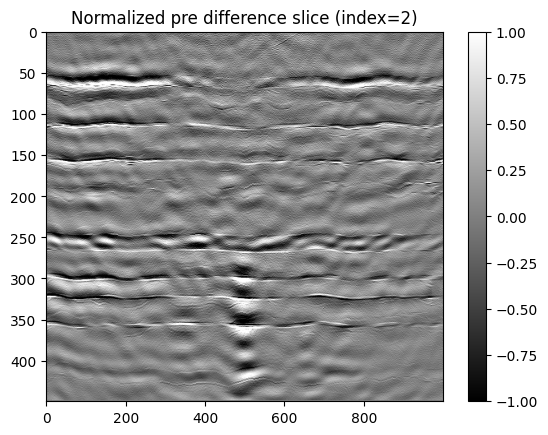

In [4]:
data_norm_pre  = dn.clip_and_normalize(image_diff_pre,  depth_windowing=450)
data_norm_post = dn.clip_and_normalize(image_diff_post, depth_windowing=450)
print("data_norm_pre shape:", data_norm_pre.shape)
print("data_norm_post shape:", data_norm_post.shape)

# Quick visualize a single slice
idx = 2
plt.imshow(data_norm_post[idx].T, aspect="auto", cmap="gray")
plt.colorbar()
plt.title("Normalized pre difference slice (index=2)")
plt.show()


## Step 4: Build Dataset from Pre-Injection
We use pre-injection difference patches as "normal" data for training or fine-tuning.


In [5]:
data_train = dn.build_dataset_from_slices(data_norm_pre[:49],
                                          patch_size=128,
                                          slide_x=10, 
                                          slide_z=10)
print("data_train shape:", data_train.shape)


data_train shape: (142296, 1, 128, 128)


## Step 5: Load Pretrained Encoder (CAE)
Assume we have a single pretrained model. If you *don't* have it, 
you could train it here, but we'll load directly.


In [6]:
pretrained_encoder_path = "model_ae_best.pth"
encoder = dn.load_pretrained_encoder(pretrained_encoder_path)
encoder = encoder.to(device)
print("Loaded pretrained encoder.")


Loaded pretrained encoder.


## Step 6: Compute Embedding Center (c)
We'll pass the "normal" patches through the encoder and compute their mean embedding.


In [7]:
data_tensor = torch.FloatTensor(data_train[:,0])  # shape (#patches, patch_size, patch_size)
# Re-add channel dim in code, or just fix the `compute_center` function to handle shape. 
# We'll do a quick reshape:
data_tensor = data_tensor.unsqueeze(1)  # shape (#patches, 1, patch_size, patch_size)

c = dn.compute_center(encoder, data_tensor, device=device, eps=0.1)
print("Center shape:", c.shape)

Center shape: torch.Size([128])


## Step 7: Fine-Tune Encoder using Embedding Space Optimization
We can run epoches to move the encoder's weights so that 
patch embeddings are closer to the center c.


In [8]:
best_model_file = "encoder_best.pth"

if not os.path.exists(best_model_file):
    print(f"'{best_model_file}' does not exist. Training/fine-tuning the encoder...")
    encoder_optimized = dn.optimize_encoder(
        encoder=encoder,
        data_tensor=data_tensor, 
        center=c,
        device=device,
        lr=1e-4,
        weight_decay=5e-7,
        num_epochs=10,
        best_model_path=best_model_file
    )
else:
    print(f"'{best_model_file}' already exists. Loading the encoder from file...")
    encoder_loaded = dn.load_optimized_encoder(
        encoder_class=deepnrms.Deep_NRMS,           # pass the class, not an instance
        checkpoint_path="encoder_best.pth",
        device=device
    )

'encoder_best.pth' already exists. Loading the encoder from file...


## Step 8: Generate Anomaly Score on Post-Injection
We'll pick one post-injection slice, pass it through the encoder, and compute (z - c)^2.


In [9]:
idx_test = 
post_slice = data_norm_post[idx_test]
c = c.to(device)
score_map = dn.compute_anomaly_score(encoder_loaded, c, post_slice, device=device)

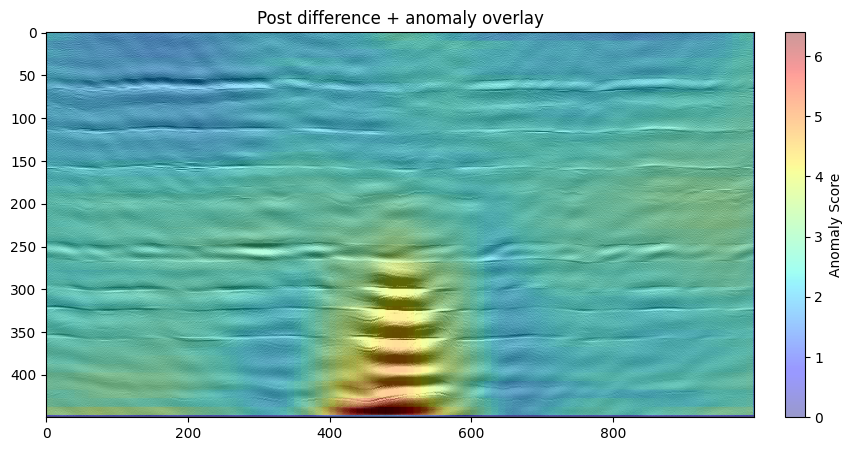

In [30]:
# co2sat = np.load("/sep/minjun/CCUS/model/co2sat.npy")
# If you also clipped the bottom 'depth_windowing=450' for seismic data,
# you might do something like:
co2sat_slice = co2sat[idx_test*2, -450:, :]  # shape (nx, 450), adjust as needed

plt.figure(figsize=(10, 5))
plt.title("Post difference + anomaly overlay")
plt.imshow(post_slice.T, aspect="auto", cmap="gray")
# Overlay the anomaly scores in color
overlay_img = plt.imshow(
    score_map.T,
    aspect="auto",
    cmap="jet",
    alpha=0.4  # Semi-transparency
)
plt.colorbar(overlay_img, fraction=0.046, pad=0.04, label="Anomaly Score")
